### In-Depth: Kernel Density Estimation

• In the previous section we covered Gaussian mixture models (GMM), which are a kind of hybrid between a clustering estimator and a density estimator.

• Recall that a density estimator is an algorithm which takes a D-dimensional dataset and produces an estimate of the D-dimensional probability distribution which that data is drawn from.

• The GMM algorithm accomplishes this by representing the density as a weighted sum of Gaussian distributions. 

• Kernel density estimation (KDE) is in some senses an algorithm which takes the mixture-of-Gaussians idea to its logical extreme: it uses a mixture consisting of one Gaussian component per point, resulting in an essentially non-parametric estimator of density. In this section, we will explore the motivation and uses of KDE.

• We begin with the standard imports:

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

### Motivating KDE: Histograms

• As already discussed, a density estimator is an algorithm which seeks to model the probability distribution that generated a dataset.

• For one dimensional data, you are probably already familiar with one simple density estimator: the histogram. A histogram divides the data into discrete bins, counts the number of points that fall in each bin, and then visualizes the results in an intuitive manner.

• For example, let's create some data that is drawn from two normal distributions:

In [3]:
def make_data(N, f=0.3, rseed=1):
    rand = np.random.RandomState(rseed)
    x = rand.randn(N)
    x[int(f * N):] += 5
    return x
x = make_data(1000)

• We have previously seen that the standard count-based histogram can be created with the plt.hist() function.

• By specifying the normed parameter of the histogram, we end up with a normalized histogram where the height of the bins does not reflect counts, but instead reflects probability density:

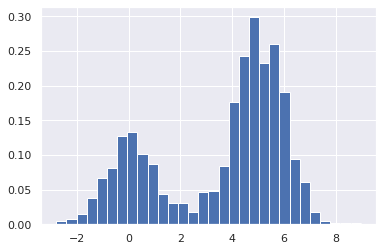

In [8]:
hist = plt.hist(x, bins=30, density=True)

• Notice that for equal binning, this normalization simply changes the scale on the y-axis, leaving the relative heights essentially the same as in a histogram built from counts.

• This normalization is chosen so that the total area under the histogram is equal to 1, as we can confirm by looking at the output of the histogram function:

In [9]:
density, bins, patches = hist
widths = bins[1:] - bins[:-1]
(density * widths).sum()

1.0

• One of the issues with using a histogram as a density estimator is that the choice of bin size and location can lead to representations that have qualitatively different features.

• For example, if we look at a version of this data with only 20 points, the choice of how to draw the bins can lead to an entirely different interpretation of the data! Consider this example:

In [10]:
x = make_data(20)
bins = np.linspace(-5, 10, 10)